In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import tensorflow as tf
from tensorflow import keras

In [2]:
end_date = datetime.now().date() - timedelta(days=15)
start_date = datetime.now().date() - timedelta(days=59)

end_date1 = datetime.now().date()
start_date1 = datetime.now().date() - timedelta(days=14)

In [3]:
symb='RELIANCE.NS'

In [4]:
df = yf.download(symb, interval='30m', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-03-16 09:30:00,2219.399902,2219.399902,2202.199951,2210.000000,2210.000000,1165669
2023-03-16 10:00:00,2210.000000,2235.949951,2207.000000,2229.000000,2229.000000,1103249
2023-03-16 10:30:00,2229.000000,2248.550049,2226.250000,2244.449951,2244.449951,766763
2023-03-16 11:00:00,2243.600098,2254.000000,2242.199951,2246.300049,2246.300049,555690
2023-03-16 11:30:00,2246.500000,2248.000000,2230.699951,2232.000000,2232.000000,457350


data=data.reset_index()

In [6]:
df.reset_index(inplace=True)

dataDF= requests.get("http://127.0.0.1:8000/api/query/ITC.NS/") 

dataD= dataDF.json()

df= pd.read_json(dataDF.json())

In [7]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-03-16 09:30:00,2219.399902,2219.399902,2202.199951,2210.000000,2210.000000,1165669
1,2023-03-16 10:00:00,2210.000000,2235.949951,2207.000000,2229.000000,2229.000000,1103249
2,2023-03-16 10:30:00,2229.000000,2248.550049,2226.250000,2244.449951,2244.449951,766763
3,2023-03-16 11:00:00,2243.600098,2254.000000,2242.199951,2246.300049,2246.300049,555690
4,2023-03-16 11:30:00,2246.500000,2248.000000,2230.699951,2232.000000,2232.000000,457350


In [8]:
df.dtypes

Datetime     datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
trainSet = df.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range=(0, 1))
trainingSetScaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

xTRAIN = []
yTRAIN = []
for i in range(60, len(trainingSetScaled)):
    xTRAIN.append(trainingSetScaled[i - 60:i, 0])
    yTRAIN.append(trainingSetScaled[i, 0])
xTRAIN, yTRAIN = np.array(xTRAIN), np.array(yTRAIN)

In [10]:
base_mdl= keras.models.load_model('../model/exports/^NSEI-LSTMv2/')

In [11]:
xTRAIN = np.reshape(xTRAIN, newshape=(xTRAIN.shape[0], xTRAIN.shape[1], 1))
regressor = keras.models.Sequential([
            keras.layers.LSTM(units=128, return_sequences=True, input_shape=(xTRAIN.shape[1], 1)),
            keras.layers.Dropout(rate=0.2),
            keras.layers.LSTM(units=64, return_sequences=True),
            keras.layers.Dropout(rate=0.3),
            keras.layers.LSTM(units=64),
            keras.layers.Dropout(rate=0.5),
            keras.layers.Dense(units=1)
        ])

In [12]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [13]:
xTRAIN.shape

(276, 60, 1)

In [14]:
regressor.compile(optimizer= 'adam', loss= keras.losses.mean_squared_error)
regressor.fit(x= xTRAIN, y=yTRAIN, batch_size= 32, epochs= 50)

Epoch 1/50
9/9 [==============================] - 5s 36ms/step - loss: 0.1460
Epoch 2/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0407
Epoch 3/50
9/9 [==============================] - 0s 18ms/step - loss: 0.0304
Epoch 4/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0208
Epoch 5/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0186
Epoch 6/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0207
Epoch 7/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0192
Epoch 8/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0171
Epoch 9/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0157
Epoch 10/50
9/9 [==============================] - 0s 18ms/step - loss: 0.0151
Epoch 11/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0185
Epoch 12/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0164
Epoch 13/50
9/9 [==============================] - 0s 21ms/st

for layer in regressor.layers:
    intermediate_layer_model = tf.keras.models.Model(inputs=regressor.input,
                                                     outputs=layer.output)
    intermediate_output = intermediate_layer_model.predict(featuresTest)
    print(layer.name)
    print(intermediate_output)

In [15]:
testDF = yf.download(symb, interval='30m', start=start_date1, end=end_date1)
realSP= testDF['Close'].values
dfTotal= pd.concat((df['Open'], testDF['Open']), axis=0)
modelInp= dfTotal[len(dfTotal)-len(testDF)-60:].values
modelInp= modelInp.reshape(-1,1)
modelInp= scaler.transform(modelInp)

xTEST= []
for i in range(60, len(modelInp)):
    xTEST.append(modelInp[i-60:i, 0])
xTEST= np.array(xTEST)
xTEST= np.reshape(xTEST, newshape= (xTEST.shape[0], xTEST.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


In [16]:
import matplotlib.pyplot as plt

4/4 [==============================] - 1s 18ms/step


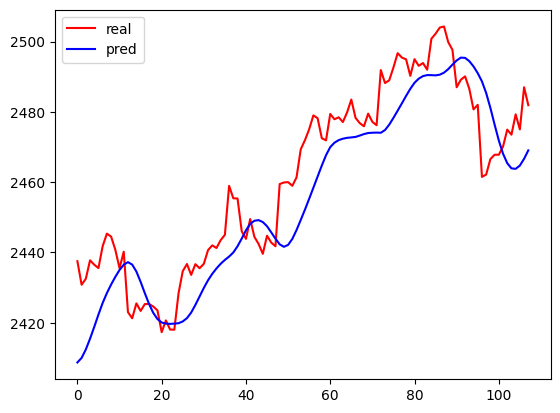

In [17]:
pred= regressor.predict(xTEST)
pred= scaler.inverse_transform(pred)
plt.plot(realSP, color= 'r', label= 'real')
plt.plot(pred, color= 'b', label= 'pred')
plt.legend()
plt.show()

In [18]:
realData= [modelInp[len(modelInp)+1-60:len(modelInp+1), 0]]
realData= np.array(realData)
realData= np.reshape(realData, newshape=(realData.shape[0], realData.shape[1], 1))
prediction= regressor.predict(realData)
prediction= scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[2471.8984]]


In [19]:
realData.shape

(1, 59, 1)

In [20]:
realSP.shape

(108,)